In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import keras.backend as K

from keras.models import Sequential, load_model  
from keras.layers.core import Dense, Activation  
from keras.layers import LSTM, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM,TimeDistributed, Flatten, Reshape
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization

%matplotlib inline
datapath = 'data/VLA2/'

/Users/emmacreeves/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Date Preprocessing
### Data files can be downloaded from [here](https://drive.google.com/drive/folders/1Ygpg6PwQ9KiXTlbuUBQQffuqpjrBx97G?usp=sharing)

data/VLA2/x_train.p (14000, 50) (6000, 50)
(4125, 50) (4125,) (1871, 50) (1871,) (1499, 50) (1499,)


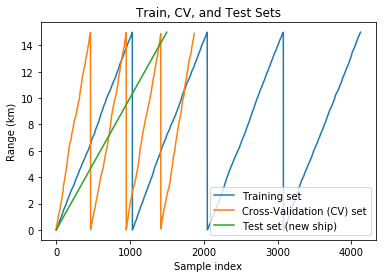

In [2]:
xtrains = sorted(glob.glob(datapath+'x_train.p')) #+ sorted(glob.glob(datapath+'x_train_VLA2_Mar25_Y*'))
ytrains = sorted(glob.glob(datapath+'y_train.p'))# + sorted(glob.glob(datapath+'y_train_VLA2_Mar25_Y*'))
xvals = sorted(glob.glob(datapath+'x_val.p')) #+ sorted(glob.glob(datapath+'x_test_VLA2_Mar25_Y*'))
yvals = sorted(glob.glob(datapath+'y_val.p'))# + sorted(glob.glob(datapath+'y_test_VLA2_Mar25_Y*'))



# intialize
Kinput = pickle.load(open(xtrains[0],'rb'))
X_training = np.empty([0,Kinput.shape[1]])
Y_training = np.empty([0,])
X_val = np.empty([0,Kinput.shape[1]])
Y_val = np.empty([0,])
X_test = pickle.load(open(datapath+'x_test.p','rb'))
Y_test = pickle.load(open(datapath+'y_test.p','rb'))

for fi in np.arange(0,len(xtrains)):
    X_training_un = pickle.load(open(xtrains[fi],'rb'))
    Y_training_un = pickle.load(open(ytrains[fi],'rb'))
    X_val_un = pickle.load(open(xvals[fi],'rb'))
    Y_val_un = pickle.load(open(yvals[fi],'rb'))
    print(xtrains[fi], X_training_un.shape, X_val_un.shape)

    X_training = np.concatenate((X_training, X_training_un), axis=0)
    Y_training = np.concatenate((Y_training, Y_training_un), axis=0)
    X_val = np.concatenate((X_val, X_val_un), axis=0)
    Y_val = np.concatenate((Y_val, Y_val_un), axis=0)

# Centering and Normalizing data
X_training = X_training[Y_training<15,:]
Y_training = Y_training[Y_training<15]
X_val = X_val[Y_val<15,:]
Y_val = Y_val[Y_val<15]
X_test = X_test[Y_test<15,:]
Y_test = Y_test[Y_test<15]

mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_test = (X_test - mux)/stdx


print(X_training.shape, Y_training.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)
plt.plot(Y_training,label='Training set')
plt.plot(Y_val,label='Cross-Validation (CV) set')
plt.ylabel('Range (km)')
plt.xlabel('Sample index')
plt.title('Train, CV, and Test Sets')
plt.plot(Y_test,label='Test set (new ship)')

plt.legend()

In [3]:
def get_model(data_dim = 50):
    input_layer = Input(shape=(data_dim,))
    hidden_layer1 = Dense(256, activation="tanh", name="hidden_layer1")(input_layer)
    batch_norm1 = BatchNormalization( name = "batch_norm_1")(hidden_layer1)
    drop1 = Dropout(0.30)(batch_norm1)
    
    hidden_layer2 = Dense(128, activation="tanh", name="hidden_layer2")(drop1)
    batch_norm2 = BatchNormalization( name = "batch_norm_2")(hidden_layer2)
    drop2 = Dropout(0.30)(batch_norm2)
    
    hidden_layer3 = Dense(64, activation="relu", name="hidden_layer3")(drop2)
    batch_norm3 = BatchNormalization( name = "batch_norm_3")(hidden_layer3)
    drop3 = Dropout(0.30)(batch_norm3)
    
    hidden_layer4 = Dense(32, activation="relu", name="hidden_layer4")(drop3)
    batch_norm4 = BatchNormalization( name = "batch_norm_4")(hidden_layer4)
    drop4 = Dropout(0.30)(batch_norm4)
    
    hidden_layer5 = Dense(32, activation="relu", name="hidden_layer5")(drop4)
    batch_norm5 = BatchNormalization( name = "batch_norm_5")(hidden_layer5)
    drop5 = Dropout(0.30)(batch_norm5)
    
    hidden_layer6 = Dense(32, activation="relu", name="hidden_layer6")(drop5)
    batch_norm6 = BatchNormalization( name = "batch_norm_6")(hidden_layer6)
    drop6 = Dropout(0.30)(batch_norm6)
    
    output_layer = Dense(1, activation="linear")(drop3)
    model = Model(inputs = input_layer, output = output_layer)
    
    return model

## Training

In [4]:
n_epochs = 250
data_dim = X_training.shape[1]
optimizer = optimizers.RMSprop(lr=1e-4)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
model = get_model(data_dim)
model.compile(loss="mean_squared_error", optimizer=optimizer)

batch_size = 50
L=len(X_training)
val_data = (X_val, Y_val)
history = model.fit(X_training, Y_training, batch_size=batch_size, epochs=n_epochs, validation_data=val_data)

/Users/emmacreeves/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 4125 samples, validate on 1871 samples
Epoch 1/250
4125/4125 [==============================] - 1s 184us/step - loss: 71.7908 - val_loss: 72.6397
Epoch 2/250
4125/4125 [==============================] - 0s 65us/step - loss: 68.6606 - val_loss: 76.5657
Epoch 3/250
4125/4125 [==============================] - 0s 64us/step - loss: 66.3388 - val_loss: 80.4270
Epoch 4/250
4125/4125 [==============================] - 0s 65us/step - loss: 65.0158 - val_loss: 80.8087
Epoch 5/250
4125/4125 [==============================] - 0s 71us/step - loss: 63.4012 - val_loss: 75.2568
Epoch 6/250
4125/4125 [==============================] - 0s 65us/step - loss: 62.0977 - val_loss: 66.3170
Epoch 7/250
4125/4125 [==============================] - 0s 65us/step - loss: 60.7764 - val_loss: 61.4034
Epoch 8/250
4125/4125 [==============================] - 0s 66us/step - loss: 58.8316 - val_loss: 58.2016
Epoch 9/250
4125/4125 [=======

4125/4125 [==============================] - 0s 75us/step - loss: 9.4424 - val_loss: 9.9870
Epoch 75/250
4125/4125 [==============================] - 0s 70us/step - loss: 9.3920 - val_loss: 13.4169
Epoch 76/250
4125/4125 [==============================] - 0s 76us/step - loss: 9.2851 - val_loss: 13.8205
Epoch 77/250
4125/4125 [==============================] - 0s 73us/step - loss: 9.4517 - val_loss: 12.3276
Epoch 78/250
4125/4125 [==============================] - 0s 76us/step - loss: 9.3723 - val_loss: 13.1764
Epoch 79/250
4125/4125 [==============================] - 0s 74us/step - loss: 9.4888 - val_loss: 10.1560
Epoch 80/250
4125/4125 [==============================] - 0s 75us/step - loss: 9.5257 - val_loss: 10.0125
Epoch 81/250
4125/4125 [==============================] - 0s 76us/step - loss: 9.0235 - val_loss: 9.4717
Epoch 82/250
4125/4125 [==============================] - 0s 74us/step - loss: 8.9898 - val_loss: 11.9158
Epoch 83/250
4125/4125 [==============================] - 0s 

Epoch 151/250
4125/4125 [==============================] - 0s 74us/step - loss: 7.2992 - val_loss: 12.3807
Epoch 152/250
4125/4125 [==============================] - 0s 74us/step - loss: 6.9570 - val_loss: 12.4378
Epoch 153/250
4125/4125 [==============================] - 0s 74us/step - loss: 7.2427 - val_loss: 13.3160
Epoch 154/250
4125/4125 [==============================] - 0s 74us/step - loss: 7.2672 - val_loss: 15.1190
Epoch 155/250
4125/4125 [==============================] - 0s 75us/step - loss: 7.0800 - val_loss: 13.5177
Epoch 156/250
4125/4125 [==============================] - 0s 73us/step - loss: 7.1205 - val_loss: 13.5118
Epoch 157/250
4125/4125 [==============================] - 0s 76us/step - loss: 6.8443 - val_loss: 16.5070
Epoch 158/250
4125/4125 [==============================] - 0s 74us/step - loss: 7.1014 - val_loss: 11.9708
Epoch 159/250
4125/4125 [==============================] - 0s 75us/step - loss: 6.8226 - val_loss: 16.0169
Epoch 160/250
4125/4125 [============

4125/4125 [==============================] - 0s 76us/step - loss: 5.8341 - val_loss: 14.9361
Epoch 228/250
4125/4125 [==============================] - 0s 74us/step - loss: 5.6138 - val_loss: 19.9781
Epoch 229/250
4125/4125 [==============================] - 0s 75us/step - loss: 5.7937 - val_loss: 19.1435
Epoch 230/250
4125/4125 [==============================] - 0s 74us/step - loss: 5.7937 - val_loss: 17.1184
Epoch 231/250
4125/4125 [==============================] - 0s 71us/step - loss: 5.5844 - val_loss: 19.2218
Epoch 232/250
4125/4125 [==============================] - 0s 76us/step - loss: 5.8195 - val_loss: 14.5840
Epoch 233/250
4125/4125 [==============================] - 0s 71us/step - loss: 5.7514 - val_loss: 14.5727
Epoch 234/250
4125/4125 [==============================] - 0s 71us/step - loss: 5.5562 - val_loss: 16.5226
Epoch 235/250
4125/4125 [==============================] - 0s 70us/step - loss: 5.5037 - val_loss: 19.6904
Epoch 236/250
4125/4125 [==========================

## Testing

In [5]:
fig = plt.figure()

preds = model.predict(X_val)
preds2 = model.predict(X_training)
preds3 = model.predict(X_test)

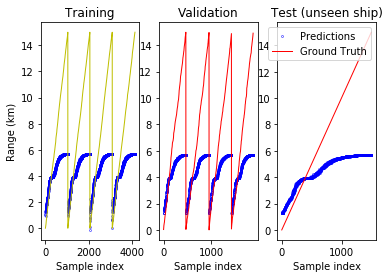

Training set RMSE = 4.412821293198756 km
Validation set RMSE = 3.3584314185855613 km
Test set RMSE = 4.379965387401816 km


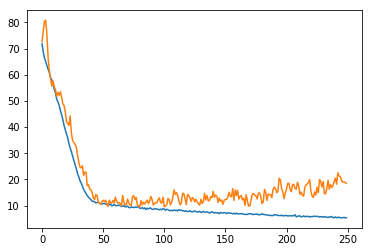

In [6]:
plt.subplot(131)
plt.plot(preds2,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_training,'y',linewidth=1.0)
#plt.legend(['Training Set', 'Ground Truth'])
plt.xlabel('Sample index')
plt.ylabel('Range (km)')
plt.title('Training')

RMSE_Ytrain = np.sqrt(np.mean(np.square(np.abs(Y_training-preds2[:,0]))))


plt.subplot(132)
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_val,'r',linewidth=1.0)
#plt.legend(['Predictions', 'Ground Truth'])
plt.xlabel('Sample index')
#plt.ylabel('Range (km)')
plt.title('Validation')

RMSE_Yval = np.mean(np.abs(Y_val-preds[:,0]))

plt.subplot(133)
plt.plot(preds3,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)
#plt.plot(Y_training,'y',linewidth=1.0)
plt.legend(['Predictions', 'Ground Truth'])
plt.xlabel('Sample index')
#plt.ylabel('Range (km)')
plt.title('Test (unseen ship)')
plt.savefig('test_noisy_simulation.pdf')
plt.show()


RMSE_Ytest = np.sqrt(np.mean(np.square(np.abs(Y_test-preds3[:,0]))))

print('Training set RMSE = ' + str(RMSE_Ytrain) + ' km')
print('Validation set RMSE = ' + str(RMSE_Yval) + ' km')
print('Test set RMSE = ' + str(RMSE_Ytest) + ' km')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])



In [7]:
# # Save model
# model.save('model_mlp.h5')

# # Load saved model
# model = load_model('model_mlp.h5')

## Visualizing Activations

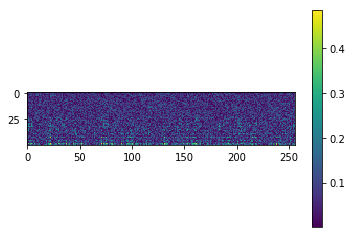

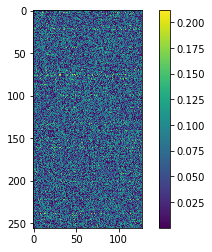

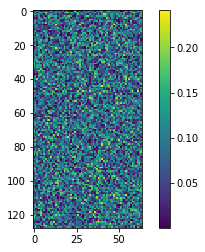

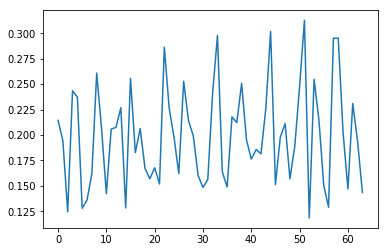

In [8]:
weights = model.get_weights()
k=0
for i in range(len(weights)):
    shape = weights[i].shape
    if(len(shape)>1):
        fileName = "mlp_weights_layer_{}.png".format(k)
        plt.figure()
        if((shape[0]>1) & (shape[1]>1)):
            plt.imshow(np.abs(weights[i]))
            plt.colorbar()
        else:
            plt.plot(np.abs(weights[i]))   
       # plt.savefig(fileName)
plt.show()

## Visualizing Activations

In [9]:
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    activations = []
    inp = model.input
    
    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)

    return activations

(1, 256)


/Users/emmacreeves/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


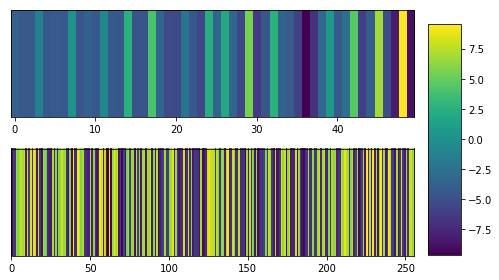

In [10]:
test_sample_num = 0
activation_map = get_activations(model, np.reshape(X_test[test_sample_num,:], (1, X_test.shape[1])))
layers = [0, 3]#, 6, 9, 10]
print(activation_map[3].shape)

for key, layer in enumerate(layers):
    
    activations = activation_map[layer][0]
    subplot_num = len(layers)*100 + 1*10 + key+1
    plt.subplot(subplot_num)
    plt.gca().get_yaxis().set_visible(False)
    plt.imshow(np.reshape(activations, (1, len(activations))), interpolation = 'nearest', aspect='auto')
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.tight_layout()
plt.colorbar(cax=cax)
plt.show()